In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import warnings
from matplotlib.lines import Line2D
import scipy.stats
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'neumodxVVLabDB',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)


In [75]:
colorDict  = {1:'#FF0000',#Red 1
              2:'#00B050',#Green 2
              3:'#0070C0',#`Blue 3
              4:'#7030A0',#Purple 4
              5:'#808080',#Light Grey 5
              6:'#FF6600',#Orange 6
              7:'#FFCC00',#Yellow 7
              8:'#9999FF',#Light Purple 8
              9:'#333333',#Black 9
              10:'#808000',#Goldish 10
              11:'#FF99CC',#Hot Pink 11
              12:'#003300',#Dark Green 12
            }
##Function to Get Channel Data (i.e. Green Raw, Red Normalized etc.)
def getSQLData_Channel(color, dtype, assay, start_time_filter, end_date_filter,system,assay_version,cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_"+color+"_"+dtype+"_Master]"+
             "where ([Result Code] like '%"+assay+"%') and [Start Time]>'"+start_time_filter+"'"+
             " and [Start Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+
             "%' and ([Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    return df


##Function to Get Channel Data (i.e. Green Raw, Red Normalized etc.)             
def getSQLData_COC(assay, start_time_filter, end_date_filter, system, assay_version, cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_System_Master_Table]"+
             " where ([Result Code] like '%"+assay+"%') and [Start Date Time]>'"+start_time_filter+"'"+
             " and [Start Date Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+"%' and ([Pcr Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    
    return df.set_index(['PCR Module Serial', 'Pcr Cartridge Lane'])




NormDataDict_PCR = {}
RawDataDict_PCR = {}
SecondDataDict_PCR = {}
stardate = '2022-02-18'
enddate = '2022-12-31'
assayname = 'FRS1'
#prefix = ['A','B','C','D','E','R','J','K','L','Q','H','I','F','G']
prefix = ['FRSPC']
##getSQLData_COC args (Result Code, Start Date, End Date, N500 Serial Number, cartridge lot 1, cartridge lot 2, cartridge lot 3, cartridge lot 4)
COC_PCR = getSQLData_COC(assayname, stardate, enddate, '', '', '', '', '', '')
##Excluding V1045
#COC_PCR = COC_PCR[(COC_PCR['Extraction Module Serial'] != 'V1045')]
COC_PCR = COC_PCR[(COC_PCR['Sample ID'].str[:5].isin(prefix))]


##getSQLData_Channel args (Result Code, Channel, Start Date, End Date, N500 Serial Number, Assay Version, cartridge lot 1, cartridge lot 2, cartridge lot 3, cartridge lot 4)
for channel in ['Green','Yellow', 'Orange', 'Far_Red', 'Red']:
    
    # NormDataDict_PCR[channel] = getSQLData_Channel(channel,'Normalized',assayname, stardate, enddate, '', '', '', '', '', '')
    RawDataDict_PCR[channel] = getSQLData_Channel(channel,'Raw', assayname, stardate, enddate, '', '', '', '', '', '')
    # SecondDataDict_PCR[channel]= getSQLData_Channel(channel,'2nd',assayname, stardate, enddate, '', '', '', '', '', '')
    ##Excluding V1045
    #NormDataDict_PCR[channel] = NormDataDict_PCR[channel][(NormDataDict_PCR[channel]['XPCR Module Serial'] != 'V1045')]
    #RawDataDict_PCR[channel] = RawDataDict_PCR[channel][(RawDataDict_PCR[channel]['XPCR Module Serial'] != 'V1045')]
    #SecondDataDict_PCR[channel] = SecondDataDict_PCR[channel][(SecondDataDict_PCR[channel]['XPCR Module Serial'] != 'V1045')]
    ##Excluding V1045 
    
    # NormDataDict_PCR[channel] = NormDataDict_PCR[channel][(NormDataDict_PCR[channel]['Sample ID'].str[:5].isin(prefix))]
    RawDataDict_PCR[channel] = RawDataDict_PCR[channel][(RawDataDict_PCR[channel]['Sample ID'].str[:5].isin(prefix))]
    # SecondDataDict_PCR[channel] = SecondDataDict_PCR[channel][(SecondDataDict_PCR[channel]['Sample ID'].str[:5].isin(prefix))]


    # NormDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane',  'Test Guid'],inplace=True)
    RawDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    # SecondDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    # NormDataDict_PCR[channel].sort_index(inplace=True)


Query: Select * from [dbo].[NeuMoDx_System_Master_Table] where ([Result Code] like '%FRS1%') and [Start Date Time]>'2022-02-18' and [Start Date Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%')
Query: Select * from [dbo].[NeuMoDx_Green_Raw_Master]where ([Result Code] like '%FRS1%') and [Start Time]>'2022-02-18' and [Start Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%')
Query: Select * from [dbo].[NeuMoDx_Yellow_Raw_Master]where ([Result Code] like '%FRS1%') and [Start Time]>'2022-02-18' and [Start Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Cartridge Barcode] like '%%' OR [Cartridge Ba

In [76]:
##Returns Consumable Information for each module included in Dataset Takes Chain of Custody Data as input
def generateLotTable(data):
    LotDataBase = data.sort_values('Start Date Time')

    #stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    #results_Stats = ['Amp','NotAmp','NoResult','Sample Size']
    #LotDataBase['Run Number'] = np.nan
    for mod in LotDataBase.index.unique(0):
        LotDataBase.loc[mod, 'Time Difference'] = LotDataBase.loc[mod, 'Start Date Time'].diff().values / np.timedelta64(1, 's')
        LotDataBase.loc[mod, 'Time Difference'] = np.where(LotDataBase.loc[mod, 'Time Difference'].isnull(),50000,LotDataBase.loc[mod, 'Time Difference'])
        LotDataBase.loc[mod, 'New Run?'] = np.where(LotDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        LotDataBase.loc[(mod, (LotDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(LotDataBase.loc[mod, LotDataBase['New Run?']==1,:])+1)
        LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']] = LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']].fillna(method='ffill').values

    LotDataBase.reset_index(inplace=True)
    LotDataBase['Date'] = LotDataBase['Start Date Time'].dt.date
    LotDataBase.set_index(['PCR Module Serial', 'Run Number', 'Date'],inplace=True)
    LotDataBase['Cartridge Lot'] = LotDataBase['Pcr Cartridge Barcode'].str[18:24]
    LotDataBase['Cartridge Serial'] = LotDataBase['Pcr Cartridge Barcode'].str[27:32]
    LotDataBase['Test Strip Lot'] = LotDataBase['Test Strip NeuMoDx Barcode'].str[18:24]
    LotDataBase['LDT Master Mix Lot'] = LotDataBase['Test Strip LDT Master Mix Barcode'].str[18:24]
    LotDataBase['Extraction Plate Lot'] = LotDataBase['Capture Plate Barcode'].str[18:24]
    LotDataBase['Buffer Lot'] = LotDataBase['Buffer Barcode'].str[18:24]                                                 
    LotDataBase['Release Lot'] = LotDataBase['Release Reagent Barcode'].str[18:24]
    LotDataBase['Wash Lot'] = LotDataBase['Wash Reagent Barcode'].str[18:24]
    


    Lots = ['Cartridge Lot', 'Cartridge Serial', 'Test Strip Lot', 'Extraction Plate Lot', 'Buffer Lot', 'Release Lot',  'Wash Lot', 'Result Code']
    #display(LotDataBase['LotDataBase Strip Lot'].groupby(level=[0,1]).agg('unique'))
    LotDataBase_aggs = {}
    for lot_type in Lots:
        LotDataBase_by_run_agg = LotDataBase[lot_type].groupby(level=[0,1,2]).agg('unique').to_frame()
        LotDataBase_by_mod_agg = LotDataBase[lot_type].groupby(level=[0]).agg('unique').to_frame()
        LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()
        #LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()    

        LotDataBase_by_mod_agg['Run Number'] = 'Combined'
        LotDataBase_by_mod_agg['Date'] = 'Combined'
        
        LotDataBase_by_date_agg['Run Number'] = 'Combined'
        LotDataBase_by_date_agg['PCR Module Serial'] = 'Combined'
        
        LotDataBase_by_mod_agg.set_index(['Run Number','Date'],append=True,inplace=True)
        LotDataBase_by_date_agg.set_index(['Run Number', 'PCR Module Serial'],append=True,inplace=True)
        LotDataBase_by_date_agg = LotDataBase_by_date_agg.reorder_levels(['PCR Module Serial', 'Run Number', 'Date'],axis=0)
        LotDataBase_agg = pd.concat([LotDataBase_by_run_agg,LotDataBase_by_mod_agg,LotDataBase_by_date_agg],axis=0).sort_index()
        #LotDataBase_agg.sort_index(axis=1,inplace=True)
        #LotDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
        LotDataBase_aggs[lot_type] = LotDataBase_agg
    consumables = pd.concat([LotDataBase_aggs[x] for x in LotDataBase_aggs],axis=1)
    consumables.index.names = ['XPCR Module Serial', 'Run Number','Date']
    consumables.columns = pd.MultiIndex.from_tuples([(lot, '', '') for lot in consumables.columns])
    return consumables, LotDataBase[Lots+['Test Guid', 'LHPA ADP Position', 'LHPB ADP Position', 'LHPC ADP Position', 'Pcr Cartridge Lane']]

##Returns By Run Summary Information & Run Labeled Line Data for each module included in Dataset Takes Channel Data as input
def generateSummaryTable(data, channel):
    SummaryDataBase = data.sort_values('Start Time')

    stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    results_Stats = ['Amp','NotAmp','NoResult','IND', 'UNR', 'Sample Size']
    #SummaryDataBase['Run Number'] = np.nan
    for mod in SummaryDataBase.index.unique(0):
        SummaryDataBase.loc[mod, 'Time Difference'] = SummaryDataBase.loc[mod, 'Start Time'].diff().values / np.timedelta64(1, 's')
        SummaryDataBase.loc[mod, 'Time Difference'] = np.where(SummaryDataBase.loc[mod, 'Time Difference'].isnull(),50000,SummaryDataBase.loc[mod, 'Time Difference'])
        SummaryDataBase.loc[mod, 'New Run?'] = np.where(SummaryDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        SummaryDataBase.loc[(mod, (SummaryDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(SummaryDataBase.loc[mod, SummaryDataBase['New Run?']==1,:])+1)
        SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']] = SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']].fillna(method='ffill').values

    SummaryDataBase['NotAmp'] = np.where(SummaryDataBase['Target Result']=='TargetNotAmplified',1,0)
    SummaryDataBase['Amp'] = np.where(SummaryDataBase['Target Result']=='TargetAmplified',1,0)
    SummaryDataBase['NoResult'] = np.where(SummaryDataBase['Target Result']=='NoResult',1,0)
    SummaryDataBase['IND'] = np.where(SummaryDataBase['Target Result']=='TargetIndeterminate',1,0)
    SummaryDataBase['UNR'] = np.where(SummaryDataBase['Target Result']=='TargetUnresolved',1,0)
    SummaryDataBase['Abort'] = np.where(SummaryDataBase['Target Result']=='TargetAborted',1,0)
    SummaryDataBase['Sample Size'] = SummaryDataBase[['NotAmp','Amp','NoResult','IND','UNR']].sum(axis=1)

    SummaryDataBase.loc[:,['NotAmp','Amp','IND','UNR','NoResult','Sample Size']]



    SummaryDataBase.reset_index(inplace=True)
    SummaryDataBase.set_index(['XPCR Module Serial','Run Number'],inplace=True)
    SummaryDataBase.loc[:,stats] =  SummaryDataBase.loc[:,stats].astype(float)

    SummaryDataBase.to_csv('SummaryDataBase.csv')

    agg_dict = {}
    agg_dict['Start Time'] = ['first','last']
    for stat in results_Stats:
        agg_dict[stat] = ['sum']
    for stat in stats:
        agg_dict[stat] = ['mean','std','count']
    agg_dict

    SummaryDataBase_by_run_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0,1]).agg(agg_dict)



    SummaryDataBase_by_mod_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0]).agg(agg_dict)


    SummaryDataBase_by_mod_agg['Run Number'] = 'Combined'
    SummaryDataBase_by_mod_agg.set_index('Run Number',append=True,inplace=True)

    SummaryDataBase_agg = pd.concat([SummaryDataBase_by_run_agg,SummaryDataBase_by_mod_agg],axis=0).sort_index()

    SummaryDataBase_agg[('Ct Calls','')] = SummaryDataBase_agg[('Ct','count')]
    for param in SummaryDataBase_agg.columns.unique(0):
        if param in stats:
            SummaryDataBase_agg[(param, '%CV')] = SummaryDataBase_agg[(param, 'std')] / SummaryDataBase_agg[(param, 'mean')]
            SummaryDataBase_agg.drop([(param,'count')],axis=1,inplace=True)
    SummaryDataBase_agg.sort_index(axis=1,inplace=True)
    SummaryDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
    SummaryDataBase_agg.columns = pd.MultiIndex.from_tuples([(channel,x,y) for x,y in SummaryDataBase_agg.columns])
    SummaryDataBaseagg = SummaryDataBase_agg.loc[:,channel]
    SummaryDataBaseagg[('% Amp', '')] = SummaryDataBaseagg[('Amp', 'sum')] / (SummaryDataBaseagg[('Amp', 'sum')] + SummaryDataBaseagg[('NotAmp', 'sum')])
    SummaryDataBaseagg = SummaryDataBaseagg.loc[:,['Start Time', '% Amp', 'Amp','NotAmp','NoResult', 'IND', 'UNR', 'Sample Size', 'Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']].droplevel(2,axis=0)
    SummaryDataBaseagg.columns = pd.MultiIndex.from_tuples([('Start Time', 'first sample'),
                                                 ('Start Time', 'last sample'),
                                                 ('% AMP', ''),
                                                 ('Amp', '') ,
                                                 ('NotAmp', '') ,
                                                 ('NoResult', ''),
                                                 ('UNR', '') ,
                                                 ('IND', '') ,
                                                 ('Sample Size', ''),
                                                 ('Ct', '%CV') ,
                                                 ('Ct', 'mean') ,
                                                 ('Ct', 'std') ,
                                                 ('End Point Fluorescence', '%CV') ,
                                                 ('End Point Fluorescence', 'mean') ,
                                                 ('End Point Fluorescence', 'std'),
                                                 ('Max Peak Height', '%CV') ,
                                                 ('Max Peak Height', 'mean') ,
                                                 ('Max Peak Height', 'std') ,
                                                 ('EPR', '%CV') ,
                                                 ('EPR', 'mean') ,
                                                 ('EPR', 'std')])
    return SummaryDataBaseagg, SummaryDataBase

In [77]:
mods = ['V949']
COC_PCR = COC_PCR.loc[([x for x in COC_PCR.index.unique(0) if pd.isnull(x)==False],
                       [x for x in COC_PCR.index.unique(1) if pd.isnull(x)==False]),:]

#DF = generateLotTable(COC_PCR).join(generateSummaryTable(RawDataDict_PCR['Yellow'],'Yellow'))
channelData = {}    

channelData['Green'] = generateSummaryTable(RawDataDict_PCR['Green'], 'Green')
channelData['Yellow'] =  generateSummaryTable(RawDataDict_PCR['Yellow'], 'Yellow')
channelData['Orange'] =  generateSummaryTable(RawDataDict_PCR['Orange'], 'Orange')
channelData['Far_Red'] =  generateSummaryTable(RawDataDict_PCR['Far_Red'], 'Far_Red')
channelData['Red'] =  generateSummaryTable(RawDataDict_PCR['Red'], 'Red')

consumables = generateLotTable(COC_PCR)
#channelData['Far_Red'][0].loc[mods]

In [78]:
##Step 1A Get Consumables used for Testing By Date.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x == 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))



##Step 1B Get Consumables used for Testing By Module.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x != 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))

##Step 1C Get Consumables used for Testing By Module Run.
display(HTML(consumables[0].loc[(slice(None),[x for x in consumables[0].index.unique(1) if x != 'Combined']),:].reset_index()\
     .style.hide_index()\
     .format(subset=['Run Number'], formatter='{:.0f}')\
     .to_html()))

XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
Combined,Combined,2022-02-18,['107589'],['07647' '03752'],['11501Z' '11500X'],['116834' '113634'],['116729'],['113219'],['113942'],['FRS1']
Combined,Combined,2022-02-21,['107589'],['00817' '01929' '00816' '00809' '00808'],['11500X' '11501Y' '11501Z'],['116834' '113634'],['112653' '116729'],['113219' '116005'],['113945' '113942'],['FRS1']
Combined,Combined,2022-02-22,['107589'],['00968' '00908' '00969' '03530'],['11501Z' '11500X'],['116834'],['116729' '112653'],['113219' '116005'],['113945' '113942'],['FRS1']
Combined,Combined,2022-02-23,['107589'],['01513' '02612' '01508'],['11501Y' '11501Z'],['116834'],['112653' '116729'],['113219'],['113942' '113945'],['FRS1']
Combined,Combined,2022-02-24,['107589'],['02703' '01804' '01239'],['11501Y' '11501Z'],['116834'],['112653' '114918'],['113219'],['113942'],['FRS1']
Combined,Combined,2022-02-25,['107589'],['03025' '03027' '02896'],['11500X'],['116834'],['116729'],['113219'],['113942'],['FRS1']
Combined,Combined,2022-03-01,['107589'],['03724' '06789' '02962' '01567'],['11500X'],['116834' '114184'],['114918'],['113219' '116005'],['113945' '113942'],['FRS1']
Combined,Combined,2022-03-02,['107589'],['00690' '02499' '00906' '02354'],['11500X' '11501Z'],['114184'],['116469' '114918'],['113219' '116005' '116337'],['113945' '113942'],['FRS1']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1039,Combined,Combined,['107589'],['00808' '02962' '03052'],['11501Z' '11500X' '11501Y'],['113634' '114184'],['116729' '114918' '116469'],['116005'],['113942' '113945'],['FRS1']
V223,Combined,Combined,['107589'],['00817' '03088' '03082' '02421' '00776' '00221' '02679'],['11500X' '11845X' '11501Z'],['116834' '113599' '113600'],['112653' '118055' '118141'],['113219' '113222'],['113945'],['FRS1']
V31,Combined,Combined,['107589'],['07647' '00816' '00908' '01513' '01567' '02354' '00692' '03204' '02167' '06939'],['11501Z' '11500X' '11501Y' ''],['116834' '114184' '113599' '113600'],['116729' '112653' '114918'],['113219' '116337'],['113942' '113945'],['FRS1']
V688,Combined,Combined,['107589'],['03752'],['11500X'],['113634'],['116729'],['113219'],['113942'],['FRS1']
V689,Combined,Combined,['107589'],['00690' '03494' '06843' '01744' '07637' '02415' '03085' '02793' '00079' '06911' '02143'],['11500X' '11501Y' '11673X' '11845Y' '11845X' ''],['114184' '116834' '116342' '113599'],['116469' '118055' '114918' '112653' '118141'],['113219' '113222'],['113945' '113942'],['FRS1']
V705,Combined,Combined,['107589'],['00968' '02612' '03724' '02457' '01460' '01776' '01779' '03537' '00078' '02261' '06239' '05798' '03086' '03083' '02794' '02422' '00773' '00890' '06579'],['11501Z' '11500X' '11673X' '11845Y' '11845X' ''],['116834' '114184' '116342' '113599' '113600'],['116729' '114918' '116469' '118055' '112653' '118141'],['113219' '113222'],['113945' '113942'],['FRS1']
V729,Combined,Combined,['107589'],['01508'],['11501Y'],['116834'],['116729'],['113219'],['113942'],['FRS1']
V73,Combined,Combined,['107589'],['00081' '03089' '03084' '03609' '00223' '02144'],['11500X' '11845X'],['113599'],['118055' '112653' '118141'],['113219' '113222'],['113945'],['FRS1']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1039,1,2022-02-21,['107589'],['00808'],['11501Z'],['113634'],['116729'],['116005'],['113942'],['FRS1']
V1039,2,2022-03-01,['107589'],['02962'],['11500X'],['114184'],['114918'],['116005'],['113945'],['FRS1']
V1039,3,2022-03-03,['107589'],['03052'],['11501Y'],['114184'],['116469'],['116005'],['113945'],['FRS1']
V223,1,2022-02-21,['107589'],['00817'],['11500X'],['116834'],['112653'],['113219'],['113945'],['FRS1']
V223,2,2022-03-30,['107589'],['03088'],['11845X'],['113599'],['118055'],['113222'],['113945'],['FRS1']
V223,3,2022-03-30,['107589'],['03082'],['11845X'],['113599'],['118055'],['113222'],['113945'],['FRS1']
V223,4,2022-03-31,['107589'],['02421'],['11845X'],['113599'],['118055'],['113222'],['113945'],['FRS1']
V223,5,2022-03-31,['107589'],['00776'],['11845X'],['113599'],['118055'],['113222'],['113945'],['FRS1']


In [79]:
##Define Color Dictionary to use for PCR curves & other plots for up to 36 categories
ColorDict36  = {1:'#FF0000',#Red 1
              2:'#00B050',#Green 2
              3:'#0070C0',#Blue 3
              4:'#7030A0',#Purple 4
              5:'#808080',#Light Grey 5
              6:'#FF6600',#Orange 6
              7:'#FFCC00',#Yellow 7
              8:'#9999FF',#Light Purple 8
              9:'#333333',#Black 9
              10:'#808000',#Goldish 10
              11:'#FF99CC',#Hot Pink 11
              12:'#003300',#Dark Green 12
              13:'#FF0000',#Red 1
              14:'#00B050',#Green 2
              15:'#0070C0',#Blue 3
              16:'#7030A0',#Purple 4
              17:'#808080',#Light Grey 5
              18:'#FF6600',#Orange 6
              19:'#FFCC00',#Yellow 7
              20:'#9999FF',#Light Purple 8
              21:'#333333',#Black 9
              22:'#808000',#Goldish 10
              23:'#FF99CC',#Hot Pink 11
              24:'#003300',#Dark Green 12  
              25:'#FF0000',#Red 1
              26:'#00B050',#Green 2
              27:'#0070C0',#Blue 3
              28:'#7030A0',#Purple 4
              29:'#808080',#Light Grey 5
              30:'#FF6600',#Orange 6
              31:'#FFCC00',#Yellow 7
              32:'#9999FF',#Light Purple 8
              33:'#333333',#Black 9
              34:'#808000',#Goldish 10
              35:'#FF99CC',#Hot Pink 11
              36:'#003300',#Dark Green 12  
            }

styleDict36 = {1: 'solid',
              2: 'solid',
              3: 'solid',
              4: 'solid',
              5: 'solid',
              6: 'solid',
              7: 'solid',
              8: 'solid',
              9: 'solid',
              10: 'solid',
              11: 'solid',
              12: 'solid',
              13: 'dashed',
              14: 'dashed',
              15: 'dashed',
              16: 'dashed',
              17: 'dashed',
              18: 'dashed',
              19: 'dashed',
              20: 'dashed',
              21: 'dashed',
              22: 'dashed',
              23: 'dashed',
              24: 'dashed',
              25: 'dashdot',
              26: 'dashdot',
              27: 'dashdot',
              28: 'dashdot',
              29: 'dashdot',
              30: 'dashdot',
              31: 'dashdot',
              32: 'dashdot',
              33: 'dashdot',
              34: 'dashdot',
              35: 'dashdot',
              36: 'dashdot'}

<Figure size 432x288 with 0 Axes>

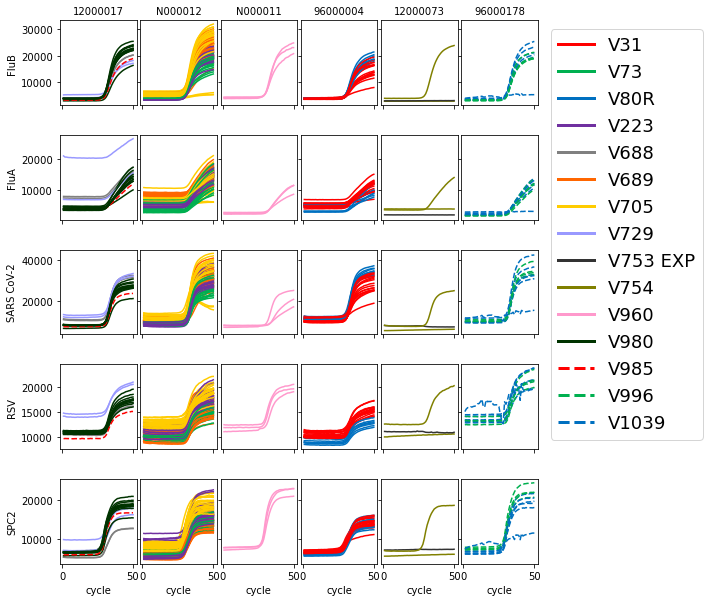

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [80]:
##Step 2: Plot Amplification Curves for All Samples Included in Testing

##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "").replace("R", "")))#Define Channels to Include in Plots
sytms = sorted(COC_PCR['N500 Serial Number'].to_list())
sytms = list(set(sytms))
##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Yellow', 'Green', 'Orange','Far_Red','Red']

#Define Targets to Include in Plots
target_names = ['FluA', 'FluB', 'SARS-CoV-2', 'RSV', 'SPC2']

#Define Target / Channel Combinations
targets = {'Green':'FluA',
           'Yellow':'FluB',
           'Orange':'SARS CoV-2',
           'Far_Red':'RSV',
           'Red':'SPC2'}

channelDataDict = {}
channelData = {}    

channelData['Green'] = generateSummaryTable(RawDataDict_PCR['Green'], 'Green')
channelData['Yellow'] =  generateSummaryTable(RawDataDict_PCR['Yellow'], 'Yellow')
channelData['Orange'] =  generateSummaryTable(RawDataDict_PCR['Orange'], 'Orange')
channelData['Far_Red'] =  generateSummaryTable(RawDataDict_PCR['Far_Red'], 'Far_Red')
channelData['Red'] =  generateSummaryTable(RawDataDict_PCR['Red'], 'Red')

#consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(len(channels), len(sytms)+1, figsize=(10,10),sharey='row',sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.35)

for channel in channels:

    channelData[channel][1].loc[:,'Cartridge Lot'] = channelData[channel][1].loc[:,'Cartridge Barcode'].str[18:24]

    channelplotdata = channelData[channel][1]#.join(treatment_key)
    channelplotdata = channelplotdata.loc[~channelplotdata['Test Guid'].isin(exclude_list),:]
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)
    
    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot','N500 Serial Number'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
    ##Remove Entries that do not have a XPCR Module (i.e. No Result Samples)
    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    
    #Plot each line in channelplotdata 
    for mod, run, lane in channelplotdata.index.unique():
                
        if mod in mods:
            guid = channelplotdata.loc[(mod,run,lane), 'Test Guid']
            
            syt = channelplotdata.loc[(mod,run,lane), 'N500 Serial Number']
            target = channelplotdata.loc[(mod,run,lane), 'Target Name']
            
            #Ensure that iteration guid is not in exclude list, if it is not then plot the data.
            if guid not in exclude_list:
                X = np.arange(1,51,1)
                Y = channelplotdata.loc[(mod,run,lane), ['Readings '+str(read) for read in range(1,51,1)]]
                sns.lineplot(x=X,y=Y, color=ColorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],ax=axs[channels.index(channel),sytms.index(syt)])
                axs[0,sytms.index(syt)].set_title(syt,fontsize=10, color='k')
                
       
    for syt in sytms:
        if channels.index(channel) == len(channels)-1:
                axs[channels.index(channel),sytms.index(syt)].set_xlabel('cycle')
            
    axs[channels.index(channel),0].set_ylabel(targets[channel])

legend_elements = []
for mod in mods:
    newLabel = Line2D([0], [0], color=ColorDict36[mods.index(mod)+1], linestyle=styleDict36[mods.index(mod)+1], lw=3,label=mod)
    legend_elements.append(newLabel)

axs[0,len(sytms)].legend(handles=legend_elements, fontsize=18,loc='upper left',ncol=1)


## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# for row in range(0,len(channels)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(channels)):
    axs[row,len(sytms)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

In [81]:

def performParameterComparison4PlexV1(data, param, grouper, groups, include_color):
    display_stats = True
    target_colors = {'FluB':'Yellow', 'FluA':'Green', 'SARS-CoV-2':'Orange', 'RSV':'Far_Red', 'SPC2':'Red'}
    color_targets  = {'Yellow':'FluB', 'Green':'FluA', 'Orange':'SARS-CoV-2', 'Far_Red':'RSV', 'Red':'SPC2'}
    target_names = ['FluA','FluB','SARS-CoV-2', 'RSV', 'SPC2']
    
    fig,axs= plt.subplots(3,2, figsize=(10,10))
    plt.subplots_adjust(hspace=0.8,wspace=0.1)
    
    
    if np.nan in data.index.unique(0):
        PCRModChannelData=data.drop(np.nan,axis=0).copy()
    else:
        PCRModChannelData=data.copy()

    PCRModChannelData = PCRModChannelData.reset_index()
    PCRModChannelData.set_index([grouper],inplace=True)
    PCRModChannelData.sort_index(inplace=True)
    PCRModChannelData

    legend_dict = {}
    i=0
    for group in groups:
        if pd.isnull(mod) == False:
            i+=1
            legend_dict[i] = group

    

    def style_sig(v, props=''):
        return props if v < 0.05 else None


    treatments_of_interest = [x for x in legend_dict]
    groups = [legend_dict[x] for x in treatments_of_interest]

    

    legend_elements = []
    row=0
    col=0

    for target in target_names:
        legend_elements = []
        if row > 2:
            col = 1
            row = 0
        treatment_PCRModChannelData = {}
        for treatment in legend_dict:
            color = target_colors[target]
            treatment_PCRModChannelData[legend_dict[treatment]] = PCRModChannelData.loc[legend_dict[treatment], (color, param)].dropna().values
        for treatment in legend_dict:
            if treatment in treatments_of_interest:
                sns.kdeplot(treatment_PCRModChannelData[legend_dict[treatment]],color=colorDict[treatment],ax=axs[row,col])
                newLabel = Line2D([0], [0], color=colorDict[treatment], lw=3,
                                  label=str(legend_dict[treatment])+" (n= "+str(len(treatment_PCRModChannelData[legend_dict[treatment]]))+")")
                legend_elements.append(newLabel)

        axs[row,col].tick_params(axis='x', which='major', labelsize=8, width=1, length=2)
        axs[row,col].tick_params(axis='y', which='major', labelsize=0, width=1, length=2)
        axs[row,col].set_title(target+" "+param+" Comparison")
        axs

        row+=1
    axs[2,1].legend(handles=legend_elements,fontsize=14,loc='upper left', ncol=2)
    #axs[1,1].axis('Off')
    axs[2,1].axis('Off')

    plt.show()

    s = {}
#     print("Running Analysis of Variance")
    import scipy.stats as stats
    p_value_counter = pd.DataFrame(index=groups, columns=channels)

    for color in channels:
        p_value_frame = pd.DataFrame(index=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]), columns=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]))
        s_frame = pd.DataFrame(index=[x for x in treatment_PCRModChannelData], columns=pd.MultiIndex.from_product([[color],['Var']]))
        for treatment in legend_dict:
            treatment_PCRModChannelData[legend_dict[treatment]] = PCRModChannelData.loc[legend_dict[treatment], (color, param)].dropna().values

            for x in treatment_PCRModChannelData:
                for y in treatment_PCRModChannelData:

                    if x != y:
                        sx = np.var(treatment_PCRModChannelData[x], ddof=1)
                        sy = np.var(treatment_PCRModChannelData[y], ddof=1)
                        f = sy / sx
                        s_frame.loc[x, (color,'Var')] = sx
                        dfn = treatment_PCRModChannelData[y].size-1
                        dfd = treatment_PCRModChannelData[x].size-1
                        p = 1-scipy.stats.f.cdf(f, dfn, dfd)
                        p_value_frame.loc[(color, x),(color, y)] = round(1-p,2)

        p_value_frame_test = pd.DataFrame(columns=p_value_frame.loc[(color,groups), (color,groups)].index, index=p_value_frame.loc[(color,groups), (color,groups)].columns)
        p_value_frame_test.loc[(color,groups), (color,groups)] = np.where(p_value_frame.loc[(color,groups), (color,groups)]<0.05, 1, 0)
        p_value_counter.loc[:, color] = p_value_frame_test.loc[:, color].sum(axis=0)

        s[color] = s_frame
#         display(p_value_frame.loc[(color, groups), (color, groups)].style.applymap(style_sig, props='color:red;background-color:pink').format(precision=2))

    if display_stats == True:
#         print('Percentage of Comparisons with Sig. Lower\n'+param+' Var Results')
        p_value_counter['Total'] =  p_value_counter.sum(axis=1)
        p_value_counter = p_value_counter.astype(float)
        p_value_counter['% of Comparisons'] = p_value_counter['Total'] / ((len(groups)-1)*5)
#         display(p_value_counter.astype(float).style.format({'% of Comparisons':"{:,.2%}"}, precision=0).background_gradient(cmap='RdYlGn', axis=0))
        s_concat = pd.concat([s[df] for df in s],axis=1)
        s_concat = s_concat.droplevel(level=1,axis=1)
        s_concat.columns = [color_targets[color] for color in s_concat.columns]
        print(param+" Variance")
        if param == 'Ct' or param =='EPR':
            if include_color:
                display(s_concat.astype(float).loc[groups].style.background_gradient(cmap='RdYlGn_r', axis=0).format(precision=2))
            else:
                display(s_concat.astype(float).loc[groups].style.format(precision=2))

        else:
            if include_color:
                display(s_concat.astype(float).loc[groups].style.background_gradient(cmap='RdYlGn_r', axis=0).format(precision=0))
            else:
                display(s_concat.astype(float).loc[groups].style.format(precision=0))

#     print("--"*30)
    m = {}
    p_value_counter = pd.DataFrame(index=groups, columns=channels)
#     print("performing T-Test for sample means")
    for color in channels:
        p_value_frame = pd.DataFrame(index=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]), columns=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]))
        difference_frame = pd.DataFrame(index=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]), columns=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]))
        m_frame = pd.DataFrame(index=[x for x in treatment_PCRModChannelData], columns=pd.MultiIndex.from_product([[color],['mean']]))
        for treatment in legend_dict:
            if treatment in treatments_of_interest:
                treatment_PCRModChannelData[legend_dict[treatment]] = PCRModChannelData.loc[legend_dict[treatment], (color, param)].dropna().values
                for x in treatment_PCRModChannelData:
                    for y in treatment_PCRModChannelData:
                        if x != y:
                            p = 1-stats.ttest_ind(a=treatment_PCRModChannelData[y], b=treatment_PCRModChannelData[x], equal_var=False, alternative='less')[1]
                            p_value_frame.loc[(color, x),(color, y)] = round(p,2)
                            difference_frame.loc[(color, x),(color, y)] = round(np.mean(treatment_PCRModChannelData[y])-np.mean(treatment_PCRModChannelData[x]),2)
                    m_frame.loc[x, (color, 'mean')] = np.mean(treatment_PCRModChannelData[x])
                m[color] = m_frame

        p_value_frame_test = pd.DataFrame(columns=p_value_frame.loc[(color,groups), (color,groups)].index, index=p_value_frame.loc[(color,groups), (color,groups)].columns)
        p_value_frame_test.loc[(color,groups), (color,groups)] = np.where(p_value_frame.loc[(color,groups), (color,groups)]<0.05, 1, 0)
        p_value_counter.loc[:, color] = p_value_frame_test.loc[:, color].sum(axis=0)

#         display(p_value_frame.loc[(color, groups), (color, groups)].style.applymap(style_sig, props='color:red;background-color:pink').format(precision=2))

    if display_stats == True:
#         print('Percentage of Comparisons with Sig. Greater\n'+param+' Mean Results')
        p_value_counter = p_value_counter.astype(float)
        p_value_counter['Total'] =  p_value_counter.sum(axis=1)
        p_value_counter['% of Comparisons'] = p_value_counter['Total'] / ((len(groups)-1)*5)
#         display(p_value_counter.astype(float).style.format({'% of Comparisons':"{:,.2%}"}, precision=0).background_gradient(cmap='RdYlGn', axis=0))
        m_concat = pd.concat([m[df] for df in m],axis=1)
        m_concat = m_concat.droplevel(level=1,axis=1)
        m_concat.columns = [color_targets[color] for color in m_concat.columns]
        print(param+" Mean")
        if param == 'Ct':
            if include_color:
                display(m_concat.astype(float).loc[groups].style.background_gradient(cmap='bwr', axis=0).format(precision=2))
            else:
                display(m_concat.astype(float).loc[groups].style.format(precision=2))
        else:
            if include_color:
                display(m_concat.astype(float).loc[groups].style.background_gradient(cmap='RdYlGn', axis=0).format(precision=0))
            else:
                display(m_concat.astype(float).loc[groups].style.format(precision=0))

    sqrt_root = lambda x: np.sqrt(x)
    TargetFrame_SD = s_concat.applymap(sqrt_root)
    TargetFrame_Mean = m_concat
    TargetFrame_CV = TargetFrame_SD / TargetFrame_Mean
    print("Standard Deviation Calculations")
    display(TargetFrame_SD.astype(float).loc[groups].style.format(precision=2))
    print("%CV Calculations")
    if include_color:
        display(TargetFrame_CV.astype(float).style.background_gradient(cmap='RdYlGn_r', axis=0).format("{:.2%}"))
    else:
        display(TargetFrame_CV.astype(float).reset_index().rename({'index':grouper},axis=1).style.format(subset=[x for x in TargetFrame_CV if 'Module' not in x], formatter='{:.2%}').hide_index())        

        
    #print("performing Z-Test for Amp% Proportion'")
    from statsmodels.stats.proportion import proportions_ztest

    a = {}
    u = {}
    l = {}
    p_value_counter = pd.DataFrame(index=groups, columns=channels)

    for color in channels:
        p_value_frame = pd.DataFrame(index=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]), columns=pd.MultiIndex.from_product([[color],[x for x in treatment_PCRModChannelData]]))

        AmpPercFrame = PCRModChannelData.loc[:, (color, ['Target Result'])].replace({'TargetAmplified':1,'TargetNotAmplified':0,'TargetUnresolved':0,'TargetIndeterminate':0,'NoResult':np.nan}).groupby(level=0).agg(['sum', 'count'])
        AmpPercFrame.columns = ['Amp', 'n']
        AmpPercFrame[color_targets[color]+' %AMP'] = AmpPercFrame['Amp'] / AmpPercFrame['n']

        for x in treatment_PCRModChannelData:
            for y in treatment_PCRModChannelData:

                if x != y:
                    #print(x, " vs ", y)
                    counts = np.array([AmpPercFrame.loc[y, 'Amp'], AmpPercFrame.loc[x, 'Amp']])
                    nobs = np.array([AmpPercFrame.loc[y, 'n'], AmpPercFrame.loc[x, 'n']])
                    #print(counts, nobs)
                    p = proportions_ztest(counts, nobs, alternative='larger')[1]
                    if pd.isnull(p):
                        p = 1
                    p_value_frame.loc[(color, x),(color, y)] = round(p,2)
        p_value_frame_test = pd.DataFrame(columns=p_value_frame.loc[(color,groups), (color,groups)].index, index=p_value_frame.loc[(color,groups), (color,groups)].columns)
        p_value_frame_test.loc[(color,groups), (color,groups)] = np.where(p_value_frame.loc[(color,groups), (color,groups)]<0.05, 1, 0)
        p_value_counter.loc[:, color] = p_value_frame_test.loc[:, color].sum(axis=0)

        a[color] = AmpPercFrame.set_index(['n'],append=True).loc[:, color_targets[color]+' %AMP']
#         display(p_value_frame.loc[(color, groups), (color, groups)].style.applymap(style_sig, props='color:red;background-color:pink').format(precision=2))     
    if display_stats == True:
#         print('Percentage of Comparisons with\nSig Higher %AMP Results')
        p_value_counter = p_value_counter.astype(float)
        p_value_counter['Total'] =  p_value_counter.sum(axis=1)
        p_value_counter['% of Comparisons'] = p_value_counter['Total'] / ((len(groups)-1)*5)
#         if include_color:
#             display(p_value_counter.astype(float).style.format({'% of Comparisons':"{:,.2%}"}, precision=0).background_gradient(cmap='RdYlGn', axis=0))
#         else:
#             display(p_value_counter.astype(float).style.format({'% of Comparisons':"{:,.2%}"}, precision=0))
        print("Percentage Amplification Calculation")
        if include_color:
            display(pd.concat([a[df] for df in a],axis=1).loc[groups].style.format("{:,.2%}").background_gradient(cmap='RdYlGn', axis=None))
        else:
            ampsummary = pd.concat([a[df] for df in a],axis=1).loc[groups]
            display(ampsummary.reset_index().style.hide_index().format(subset=[x for x in ampsummary if 'Module' not in x], formatter='{:.2%}'))
                
    
    pd.concat([a[df] for df in a],axis=1)
    from statsmodels.stats.proportion import proportion_confint
    for channel in ['Yellow', 'Green', 'Orange','Far_Red']:
        print("Amplification Summary and Clopper-Pearson 95% CIs for "+color_targets[channel])
        TargetFrame = a[channel].to_frame()#.reset_index()
        perc_amp_col = TargetFrame.columns[0]
        TargetFrame.reset_index(inplace=True)
        TargetFrame['# POS'] = TargetFrame['n'] * TargetFrame[perc_amp_col]
        TargetFrame['# POS'] = TargetFrame['# POS'].astype(int)
        TargetFrame.set_index(grouper, inplace=True)
        for lot in TargetFrame.index:
            lcb, ucb = proportion_confint(count=TargetFrame.loc[lot,'# POS'], nobs=TargetFrame.loc[lot,'n'], alpha=(1-0.95), method='beta')
            TargetFrame.loc[lot, ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]

        TargetFrame = TargetFrame[['# POS', 'n', perc_amp_col, '95% CI LCB', '95% CI UCB']].rename({'n':'# Valid Samples'},axis=1)
        if include_color:
            display(TargetFrame.loc[:,:].style.format(subset=[x for x in TargetFrame if '%' in x], formatter='{:.2%}').background_gradient(subset=[x for x in TargetFrame if '%' in x], cmap='RdYlGn', axis=None))
        else:
            display(TargetFrame.loc[:,:].reset_index().style.hide_index().format(subset=[x for x in TargetFrame if '%' in x], formatter='{:.2%}'))


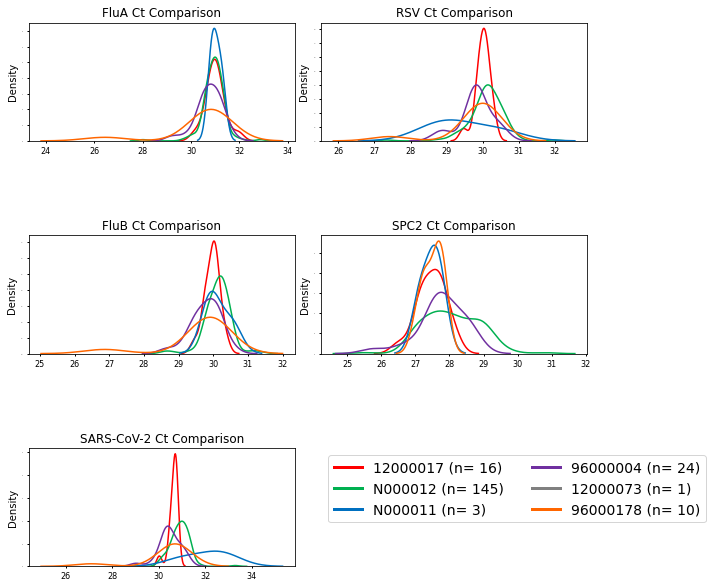

Ct Variance


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,0.05,0.16,0.04,0.04,0.17
N000012,0.15,0.22,0.20,0.24,0.67
N000011,0.13,0.05,0.98,0.78,0.09
96000004,0.19,0.29,0.23,0.21,0.47
12000073,nan,nan,nan,nan,nan
96000178,0.94,1.95,1.30,0.68,0.09


Ct Mean


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,29.96,30.99,30.64,30.00,27.47
N000012,30.13,30.94,30.90,30.11,28.07
N000011,30.13,31.03,32.07,29.45,27.46
96000004,29.78,30.74,30.47,29.81,27.76
12000073,29.72,30.49,30.43,29.87,26.96
96000178,29.61,30.39,30.34,29.74,27.51


Standard Deviation Calculations


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,0.22,0.40,0.19,0.20,0.42
N000012,0.38,0.46,0.45,0.49,0.82
N000011,0.35,0.23,0.99,0.89,0.30
96000004,0.43,0.54,0.48,0.46,0.69
12000073,nan,nan,nan,nan,nan
96000178,0.97,1.40,1.14,0.82,0.29


%CV Calculations


N500 Serial Number,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,0.73%,1.28%,0.63%,0.66%,1.52%
N000012,1.27%,1.50%,1.44%,1.62%,2.91%
N000011,1.18%,0.73%,3.09%,3.01%,1.11%
96000004,1.45%,1.75%,1.58%,1.53%,2.47%
12000073,nan%,nan%,nan%,nan%,nan%
96000178,3.28%,4.59%,3.76%,2.77%,1.07%


Percentage Amplification Calculation


N500 Serial Number,n,FluB %AMP,FluA %AMP,SARS-CoV-2 %AMP,RSV %AMP,SPC2 %AMP
12000017,16,100.00%,100.00%,100.00%,100.00%,100.00%
N000012,145,100.00%,97.93%,100.00%,100.00%,100.00%
N000011,3,100.00%,100.00%,100.00%,100.00%,100.00%
96000004,24,100.00%,100.00%,100.00%,100.00%,100.00%
12000073,3,33.33%,33.33%,33.33%,33.33%,33.33%
96000178,10,90.00%,90.00%,90.00%,90.00%,90.00%


Amplification Summary and Clopper-Pearson 95% CIs for FluB


N500 Serial Number,# POS,# Valid Samples,FluB %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


Amplification Summary and Clopper-Pearson 95% CIs for FluA


N500 Serial Number,# POS,# Valid Samples,FluA %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,142,145,97.93%,94.07%,99.57%


Amplification Summary and Clopper-Pearson 95% CIs for SARS-CoV-2


N500 Serial Number,# POS,# Valid Samples,SARS-CoV-2 %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


Amplification Summary and Clopper-Pearson 95% CIs for RSV


N500 Serial Number,# POS,# Valid Samples,RSV %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


In [82]:
#Step 3A: Perform Ct Comparison Between Modules  for all Samples (Positive, Negative, UNR & Indeterminate)
#performParameterComparison4PlexV1(data, param, grouper, groups, include_color):
performParameterComparison4PlexV1(data, 'Ct', 'N500 Serial Number', sytms, False)

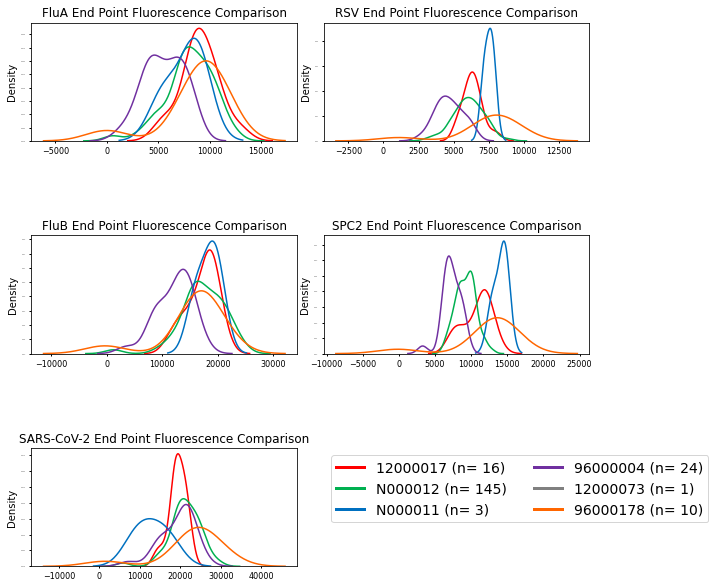

End Point Fluorescence Variance


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,7326678,3449345,4570042,495273,3761425
N000012,16963242,5471799,16273924,1224580,1900860
N000011,4367244,3260816,18033249,127033,930717
96000004,10554765,3683342,18215620,920205,1656993
12000073,nan,nan,nan,nan,nan
96000178,34154241,10547295,64186005,5594325,20533862


End Point Fluorescence Mean


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,17216,9028,19336,6344,10815
N000012,17273,8030,21145,6046,9254
N000011,18298,7628,12905,7502,14072
96000004,12168,5549,19333,4677,7274
12000073,19594,10035,17772,7651,11704
96000178,15496,8619,22610,7377,12277


Standard Deviation Calculations


,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,2706.78,1857.24,2137.77,703.76,1939.44
N000012,4118.65,2339.19,4034.10,1106.61,1378.72
N000011,2089.80,1805.77,4246.56,356.42,964.74
96000004,3248.81,1919.20,4267.98,959.27,1287.24
12000073,nan,nan,nan,nan,nan
96000178,5844.16,3247.66,8011.62,2365.23,4531.43


%CV Calculations


N500 Serial Number,FluB,FluA,SARS-CoV-2,RSV,SPC2
12000017,15.72%,20.57%,11.06%,11.09%,17.93%
N000012,23.84%,29.13%,19.08%,18.30%,14.90%
N000011,11.42%,23.67%,32.91%,4.75%,6.86%
96000004,26.70%,34.59%,22.08%,20.51%,17.70%
12000073,nan%,nan%,nan%,nan%,nan%
96000178,37.71%,37.68%,35.43%,32.06%,36.91%


Percentage Amplification Calculation


N500 Serial Number,n,FluB %AMP,FluA %AMP,SARS-CoV-2 %AMP,RSV %AMP,SPC2 %AMP
12000017,16,100.00%,100.00%,100.00%,100.00%,100.00%
N000012,145,100.00%,97.93%,100.00%,100.00%,100.00%
N000011,3,100.00%,100.00%,100.00%,100.00%,100.00%
96000004,24,100.00%,100.00%,100.00%,100.00%,100.00%
12000073,3,33.33%,33.33%,33.33%,33.33%,33.33%
96000178,10,90.00%,90.00%,90.00%,90.00%,90.00%


Amplification Summary and Clopper-Pearson 95% CIs for FluB


N500 Serial Number,# POS,# Valid Samples,FluB %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


Amplification Summary and Clopper-Pearson 95% CIs for FluA


N500 Serial Number,# POS,# Valid Samples,FluA %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,142,145,97.93%,94.07%,99.57%


Amplification Summary and Clopper-Pearson 95% CIs for SARS-CoV-2


N500 Serial Number,# POS,# Valid Samples,SARS-CoV-2 %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


Amplification Summary and Clopper-Pearson 95% CIs for RSV


N500 Serial Number,# POS,# Valid Samples,RSV %AMP,95% CI LCB,95% CI UCB
12000017,16,16,100.00%,79.41%,100.00%
12000073,1,3,33.33%,0.84%,90.57%
96000004,24,24,100.00%,85.75%,100.00%
96000178,9,10,90.00%,55.50%,99.75%
N000011,3,3,100.00%,29.24%,100.00%
N000012,145,145,100.00%,97.49%,100.00%


In [83]:
#Step 3B: Perform EP Comparison for Modules for all Samples (Positive, Negative, UNR & Indeterminate)
performParameterComparison4PlexV1(data, 'End Point Fluorescence', 'N500 Serial Number', sytms, False)

In [84]:
##Step 3A Get Overall Results Summary By Cartridge Lot
from statsmodels.stats.proportion import proportion_confint
COC_PCR['UNR'] = np.where(COC_PCR['Overall Result']=='Unresolved', 1, 0)
COC_PCR['POS'] = np.where(COC_PCR['Overall Result']=='Positive', 1, 0)
COC_PCR['NEG'] = np.where(COC_PCR['Overall Result']=='Negative', 1, 0)
COC_PCR['IND'] = np.where(COC_PCR['Overall Result']=='Indeterminate', 1, 0)
COC_PCR['NR'] = np.where(COC_PCR['Overall Result']=='NoResult', 1, 0)

Overall_Results_Summary = COC_PCR[['UNR',
                'POS',
                'NEG',
                'IND',
                'NR',
                'Cartridge Lot', 'N500 Serial Number']].groupby(['Cartridge Lot', 'N500 Serial Number']).agg({'NEG':['count','sum','mean'],
                                                                                        'POS':['sum','mean'],
                                                                                        'UNR':['sum','mean'],
                                                                                        'IND':['sum','mean'],
                                                                                        'NR':['sum','mean']})

Overall_Results_Summary.columns = ['Sample Size',
                                   'NEG #',
                                   'NEG %',
                                   'POS #',
                                   'POS %',
                                   'UNR #',
                                   'UNR %',
                                   'IND #',
                                   'IND %',
                                   'NR #',
                                   'NR %']

display(Overall_Results_Summary.style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x], formatter='{:.0f}'))


for item in Overall_Results_Summary.index:

    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'UNR #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['UNR 95% CI LCB', 'UNR 95% CI UCB']] = [lcb, ucb]
    
    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'NEG #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['NEG 95% CI LCB', 'NEG 95% CI UCB']] = [lcb, ucb]

display(Overall_Results_Summary.loc[:, [x for x in Overall_Results_Summary.columns if 'UNR' in x or 'Size' in x]].sort_index(axis=1).style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x and ('UNR' in x or 'Size' in x)], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x and ('UNR' in x or 'Size' in x)], formatter='{:.0f}'))
##Step 3B Get Overall Results Summary By Cartridge Lot / N500 Serial Number

Overall_Results_Summary = COC_PCR[['UNR',
                'POS',
                'NEG',
                'IND',
                'NR',
                'Cartridge Lot', 'N500 Serial Number']].groupby(['Cartridge Lot', 'N500 Serial Number']).agg({'NEG':['count','sum','mean'],
                                                                                        'POS':['sum','mean'],
                                                                                        'UNR':['sum','mean'],
                                                                                        'IND':['sum','mean'],
                                                                                        'NR':['sum','mean']})

Overall_Results_Summary.columns = ['Sample Size',
                                   'NEG #',
                                   'NEG %',
                                   'POS #',
                                   'POS %',
                                   'UNR #',
                                   'UNR %',
                                   'IND #',
                                   'IND %',
                                   'NR #',
                                   'NR %']


display(Overall_Results_Summary.style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x], formatter='{:.0f}'))

for item in Overall_Results_Summary.index:

    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'UNR #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['UNR 95% CI LCB', 'UNR 95% CI UCB']] = [lcb, ucb]
    
    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'NEG #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['NEG 95% CI LCB', 'NEG 95% CI UCB']] = [lcb, ucb]

display(Overall_Results_Summary.loc[:, [x for x in Overall_Results_Summary.columns if 'UNR' in x or 'Size' in x]].sort_index(axis=1).style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x and ('UNR' in x or 'Size' in x)], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x and ('UNR' in x or 'Size' in x)], formatter='{:.0f}'))
##Step 3C Get Overall Results Summary By Cartridge Lot / PCR Module Serial Number

Overall_Results_Summary = COC_PCR.reset_index()[['UNR',
                'POS',
                'NEG',
                'IND',
                'NR',
                'Cartridge Lot', 'N500 Serial Number', 'PCR Module Serial']].groupby(['Cartridge Lot', 'N500 Serial Number', 'PCR Module Serial']).agg({'NEG':['count','sum','mean'],
                                                                                        'POS':['sum','mean'],
                                                                                        'UNR':['sum','mean'],
                                                                                        'IND':['sum','mean'],
                                                                                        'NR':['sum','mean']})

Overall_Results_Summary.columns = ['Sample Size',
                                   'NEG #',
                                   'NEG %',
                                   'POS #',
                                   'POS %',
                                   'UNR #',
                                   'UNR %',
                                   'IND #',
                                   'IND %',
                                   'NR #',
                                   'NR %']





display(Overall_Results_Summary.style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x], formatter='{:.0f}'))

for item in Overall_Results_Summary.index:

    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'UNR #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['UNR 95% CI LCB', 'UNR 95% CI UCB']] = [lcb, ucb]
    
    lcb, ucb = proportion_confint(count=Overall_Results_Summary.loc[item,'NEG #'], nobs=Overall_Results_Summary.loc[item,'Sample Size'], alpha=(1-0.95), method='beta')
    Overall_Results_Summary.loc[item, ['NEG 95% CI LCB', 'NEG 95% CI UCB']] = [lcb, ucb]


display(Overall_Results_Summary.loc[:, [x for x in Overall_Results_Summary.columns if 'UNR' in x or 'Size' in x]].sort_index(axis=1).style\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '%' in x and ('UNR' in x or 'Size' in x)], formatter='{:.2%}')\
                       .format(subset=[x for x in Overall_Results_Summary.columns if '#' in x and ('UNR' in x or 'Size' in x)], formatter='{:.0f}'))

In [85]:
# #Step 3C: Perform Ct Comparison for Cartridge Lots for all Samples (Positive, Negative, UNR & Indeterminate)
# performParameterComparison4PlexV1(data, 'Ct', 'Cartridge Lot', ['118857'], False)

In [86]:
# #Step 3D: Perform Ct Comparison for Cartridge Lots for Valid Samples (Positive, Negative)
# performParameterComparison4PlexV1(data[data[('Yellow', 'Replicate Result')].isin(['Positive', 'Negative'])], 'End Point Fluorescence', 'Cartridge Lot', ['118857'], False)

In [87]:
# ##Step 4 Get Line Data
COC_PCR['Condition'] = '3x LoD'
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
COC_PCR['Cartridge Serial'] = COC_PCR['Pcr Cartridge Barcode'].str[28:32]
COC_PCR['Extraction Plate Lot'] = COC_PCR['Capture Plate Barcode'].str[18:24]
COC_PCR['Test Strip Lot'] = COC_PCR['Test Strip NeuMoDx Barcode'].str[18:24]
COC_PCR['Buffer Lot'] = COC_PCR['Buffer Barcode'].str[18:24]
COC_PCR['Wash Lot'] = COC_PCR['Wash Reagent Barcode'].str[18:24]
COC_PCR['Release Lot'] = COC_PCR['Release Reagent Barcode'].str[18:24]

##Get Target Results from data
TargetResults = data.reset_index().set_index(('Yellow', 'Test Guid')).loc[:,(slice(None),'Target Result')]
TargetResults.columns = ['Yellow Target Result', 'Green Target Result', 'Orange Target Result', 'Far Red Target Result', 'Red Target Result']
TargetResults.replace({'TargetAmplified':'AMP',
                       'TargetNotAmplified':'NotAmp',
                       'TargetIndeterminate':'IND',
                       'TargetUnresolved':'UNR',
                       'NoResult':'NR'},inplace=True)
TargetResults.index.names = ['Test Guid']

EPRs = data.reset_index().set_index(('Yellow', 'Test Guid')).loc[:,(slice(None),'EPR')]
EPRs.columns = ['Yellow Target EPR', 'Green Target EPR', 'Orange Target EPR', 'Far Red Target EPR', 'Red Target EPR']
EPRs.index.names = ['Test Guid']
MPHs = data.reset_index().set_index(('Yellow', 'Test Guid')).loc[:,(slice(None),'Max Peak Height')]
MPHs.columns = ['Yellow Target Max Peak Height', 'Green Target Max Peak Height', 'Orange Target Max Peak Height', 'Far Red Target Max Peak Height', 'Red Target Max Peak Height']
MPHs.index.names = ['Test Guid']

LineData = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).join(EPRs).join(MPHs).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
                       'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
                       'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target EP', 'Yellow Target EPR', 'Yellow Target Max Peak Height',
                       'Green Target Result', 'Green Target Ct', 'Green Target EP', 'Green Target EPR', 'Green Target Max Peak Height',
                       'Orange Target Result', 'Orange Target Ct', 'Orange Target EP', 'Orange Target EPR', 'Orange Target Max Peak Height',
                       'Far Red Target Result','Far Red Target Ct', 'Far Red Target EP', 'Far Red Target EPR', 'Far Red Target Max Peak Height',
                       'Red Target Result', 'Red Target Ct', 'Red Target EP','Red Target EPR', 'Red Target Max Peak Height',
                       'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot']]\
                        .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])


LineData.style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
                       'Pcr Cartridge Lane':'{:.0f}',
                       'Yellow Target Ct':'{:.2f}',
                       'Yellow Target EP':'{:.0f}',
                       'Yellow Target Max Peak Height':'{:.0f}',
                       'Yellow Target EPR':'{:.2f}',
                       'Green Target Ct':'{:.2f}',
                       'Green Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Orange Target Ct':'{:.2f}',
                       'Orange Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Far Red Target Ct':'{:.2f}',
                       'Far Red Target EP':'{:.0f}',
                       'Far Red Target Max Peak Height':'{:.0f}',
                       'Far Red Target EPR':'{:.2f}',
                       'Red Target Ct':'{:.2f}',
                       'Red Target EP':'{:.0f}',
                       'Red Target Max Peak Height':'{:.0f}',
                       'Red Target EPR':'{:.2f}',
                       
                       },na_rep='-').hide_index()

N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Condition,Sample ID,Start Date Time,Cartridge Lot,Cartridge Serial,Overall Result,Yellow Target Result,Yellow Target Ct,Yellow Target EP,Yellow Target EPR,Yellow Target Max Peak Height,Green Target Result,Green Target Ct,Green Target EP,Green Target EPR,Green Target Max Peak Height,Orange Target Result,Orange Target Ct,Orange Target EP,Orange Target EPR,Orange Target Max Peak Height,Far Red Target Result,Far Red Target Ct,Far Red Target EP,Far Red Target EPR,Far Red Target Max Peak Height,Red Target Result,Red Target Ct,Red Target EP,Red Target EPR,Red Target Max Peak Height,Buffer Lot,Extraction Plate Lot,Test Strip Lot,Wash Lot,Release Lot
96000004,V80R,8,3x LoD,FRSPC11607Y221104,2022-03-10 07:24:04,107589,0034,Valid,AMP,30.17,13826,4.73,751,AMP,31.70,3075,1.68,102,AMP,30.71,22822,3.120000,1948.729980,AMP,29.95,3588,1.41,256,AMP,28.49,7100,2.28,492,114918,113599,11501Y,113945,116337
96000004,V80R,10,3x LoD,FRSPC11607Y221104,2022-03-10 07:19:58,107589,0034,Valid,AMP,29.94,16044,5.02,1029,AMP,31.15,4636,1.90,167,AMP,30.50,24020,3.080000,2184.469971,AMP,29.79,4192,1.43,310,AMP,27.90,6917,2.18,498,114918,113599,11501Y,113945,116337
N000012,V705,2,3x LoD,FRSPC11607Y221104,2022-03-25 15:43:04,107589,0078,Valid,AMP,29.95,20696,5.60,1490,AMP,31.04,8043,2.57,317,AMP,30.73,22347,3.480000,2176.370117,AMP,30.16,6320,1.59,566,AMP,28.14,9677,2.35,971,112653,113600,11500X,113945,113219
N000012,V705,4,3x LoD,FRSPC11607Y221104,2022-03-25 15:40:05,107589,0078,Valid,AMP,29.98,19550,4.98,1374,AMP,31.37,6981,2.01,267,AMP,30.77,21997,3.290000,2132.060059,AMP,30.23,6094,1.56,529,AMP,28.25,9360,2.06,900,112653,113600,11500X,113945,113219
N000012,V689,2,3x LoD,FRSPC11607Y221104,2022-03-31 10:53:22,107589,0079,Valid,AMP,30.56,19671,4.73,1398,AMP,31.76,6736,2.00,241,AMP,31.14,23149,3.390000,2348.719971,AMP,30.34,6194,1.60,549,AMP,29.03,8633,2.44,714,118055,113599,11845X,113945,113222
N000012,V689,6,3x LoD,FRSPC11760X231006,2022-03-30 20:26:25,107589,0079,NoResult,NR,-,-,0.00,-,NR,-,-,0.00,-,NR,-,-,0.000000,-,NR,-,-,0.00,-,NR,-,-,0.00,-,118055,113599,11845X,113945,113222
N000012,V689,8,3x LoD,FRSPC11760X231006,2022-03-30 20:22:17,107589,0079,Valid,AMP,30.37,18417,5.09,1316,AMP,30.89,7848,1.95,324,AMP,31.21,19721,3.240000,1893.380005,AMP,30.57,5382,1.59,411,AMP,28.12,7218,2.41,536,118055,113599,11845X,113945,113222
N000012,V689,10,3x LoD,FRSPC11760X231006,2022-03-30 20:15:59,107589,0079,Valid,AMP,30.21,18089,5.06,1335,AMP,31.03,7955,2.07,334,AMP,31.00,20437,3.290000,2026.849976,AMP,30.15,5629,1.60,464,AMP,28.15,7391,2.50,564,118055,113599,11845X,113945,113222
N000012,V689,12,3x LoD,FRSPC11760X231006,2022-03-30 20:10:26,107589,0079,Valid,AMP,29.81,18559,4.32,1121,AMP,30.09,7569,1.90,290,AMP,30.33,22736,2.990000,1780.430054,AMP,29.25,5728,1.51,296,AMP,26.64,8532,2.35,567,118055,113599,11845X,113945,113222
N000012,V73,12,3x LoD,FRSPC11607Y221104,2022-03-24 15:48:44,107589,0081,Valid,AMP,30.28,12506,4.72,906,AMP,31.35,7051,2.26,264,AMP,31.09,20145,3.110000,1887.000000,AMP,30.44,5163,1.51,437,AMP,29.02,7960,2.33,607,118055,113599,11500X,113945,113219


In [88]:
# ##Step 5 Get Line Data (with Flags) for invalid Samples

# TargetResults.index.names = ['Test Guid']
# TargetResults


# LineDataInvalids = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
#                        'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
#                        'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target EP', 'Yellow Target Flag',
#                        'Green Target Result', 'Green Target Ct', 'Green Target EP', 'Green Target Flag',
#                        'Orange Target Result', 'Orange Target Ct', 'Orange Target EP','Orange Target Flag',
#                        'Far Red Target Result','Far Red Target Ct', 'Far Red Target EP', 'Far Red Target Flag',
#                        'Red Target Result', 'Red Target Ct', 'Red Target EP', 'Red Target Flag',
#                        'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot']]\
#                         .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])

# LineDataInvalids = LineDataInvalids.loc[~LineDataInvalids['Overall Result'].isin(['Positive', 'Negative'])]
# LineDataInvalids.style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
#                        'Pcr Cartridge Lane':'{:.0f}',
#                        'Yellow Target Ct':'{:.2f}',
#                        'Yellow Target EP':'{:.0f}',
#                        'Green Target Ct':'{:.2f}',
#                        'Green Target EP':'{:.0f}',
#                        'Orange Target Ct':'{:.2f}',
#                        'Orange Target EP':'{:.0f}',
#                        'Far Red Target Ct':'{:.2f}',
#                        'Far Red Target EP':'{:.0f}',
#                        'Red Target Ct':'{:.2f}',
#                        'Red Target EP':'{:.0f}',
                       
#                        },na_rep='-').hide_index()

In [89]:
# #Step 6 Plot Amplification Curves for Invalid Samples
# invalid_samples = LineDataInvalids.index.unique(0).to_list()
# ##Define Modules to Include in Plots
# mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "")))#Define Channels to Include in Plots
# ##Exclude samples by Test Guid
# exclude_list = []
# ##Define Lots to Plot
# lots = COC_PCR['Cartridge Lot'].unique().tolist()
# channels = ['Yellow', 'Green', 'Orange','Far_Red','Red']
# #Define Targets to Include in Plots
# target_names = ['FluA', 'FluB', 'SARS-CoV-2', 'RSV', 'SPC2']
# #Define Target / Channel Combinations
# targets = {'Green':'FluB',
#            'Yellow':'FluA',
#            'Orange':'SARS CoV-2',
#            'Far_Red':'RSV',
#            'Red':'SPC2'}

# channelDataDict = {}
# channelData = {}    

# channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
# channelData['Yellow'] =  generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')
# channelData['Orange'] =  generateSummaryTable(NormDataDict_PCR['Orange'], 'Orange')
# channelData['Far_Red'] =  generateSummaryTable(NormDataDict_PCR['Far_Red'], 'Far_Red')
# channelData['Red'] =  generateSummaryTable(NormDataDict_PCR['Red'], 'Red')
# consumables = generateLotTable(COC_PCR)
# plt.subplots_adjust(wspace=0.05)

# fig, axs = plt.subplots(len(channels), len(lots)+1, figsize=(10,10),sharey='row',sharex=True)
# plt.subplots_adjust(wspace=0.05,hspace=0.35)

# for channel in channels:

#     channelData[channel][1].loc[:,'Cartridge Lot'] = channelData[channel][1].loc[:,'Cartridge Barcode'].str[18:24]

#     channelplotdata = channelData[channel][1]
#     channelplotdata = channelplotdata.loc[channelplotdata['Test Guid'].isin(LineDataInvalids.index),:]
#     channelplotdata.reset_index(inplace=True)
#     channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)
    
#     channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
#     channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
#     ##Remove Entries that do not have a XPCR Module (i.e. No Result Samples)
#     if np.nan in channelplotdata.index:
#         channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    
#     #Plot each line in channelplotdata 
#     for mod, run, lane in channelplotdata.index.unique():
                
#         if mod in mods:
#             guid = channelplotdata.loc[(mod,run,lane), 'Test Guid']
            
#             lot = channelplotdata.loc[(mod,run,lane), 'Cartridge Lot']
#             target = channelplotdata.loc[(mod,run,lane), 'Target Name']
            
#             #Ensure that iteration guid is not in exclude list, if it is not then plot the data.
#             if guid not in exclude_list:
#                 X = np.arange(1,51,1)
#                 Y = channelplotdata.loc[(mod,run,lane), ['Readings '+str(read) for read in range(1,51,1)]]
#                 sns.lineplot(x=X,y=Y, color=ColorDict36[invalid_samples.index(guid)+1],linestyle=styleDict36[mods.index(mod)+1],ax=axs[channels.index(channel),lots.index(lot)])
#                 axs[0,lots.index(lot)].set_title(lot,fontsize=10, color='k')
                
       
#     for lot in lots:
#         if channels.index(channel) == len(channels)-1:
#                 axs[channels.index(channel),lots.index(lot)].set_xlabel('cycle')
            
#     axs[channels.index(channel),0].set_ylabel(targets[channel])

# legend_elements = []
# for sample in invalid_samples:
#     sampleInfo = COC_PCR[COC_PCR['Test Guid']==sample]
#     sampleString = (sampleInfo.index.unique(0).values[0] + " Lane " +
#                     str(int(sampleInfo.index.unique(1).values[0]))+"\nCartridge Serial: "+
#                     sampleInfo['Cartridge Serial'].values[0]+"\nSample ID: "+
                    
#                     sampleInfo['Sample ID'].values[0]
#                    )
#     newLabel = Line2D([0], [0], color=ColorDict36[invalid_samples.index(sample)+1], linestyle=styleDict36[invalid_samples.index(sample)+1], lw=3,label=sampleString)
#     legend_elements.append(newLabel)

# axs[0,len(lots)].legend(handles=legend_elements, fontsize=12,loc='upper left',ncol=1)


# ## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# # for row in range(0,len(channels)):
# #     axs[row,0].invert_yaxis()
    


# for row in range(0,len(channels)):
#     axs[row,len(lots)].axis('Off')
# plt.show()


In [90]:
pd.set_option("display.max_columns", None)
data

Yellow  \
                                                                                      Ct   
XPCR Module Serial Run Number Cartridge Lane Cartridge Lot N500 Serial Number              
V1039              1          9.0            107589        96000178            29.820000   
                              11.0           107589        96000178            29.840000   
                   2          9.0            107589        96000178            29.770000   
                              11.0           107589        96000178            29.730000   
                   3          5.0            107589        96000178            29.920000   
...                                                                                  ...   
V985               1          10.0           107589        12000017            30.000000   
V996               1          9.0            107589        96000178            30.070000   
                              11.0           107589        96000178            29.879999   
                   2          9.0            107589        96000178            30.160000   
                              11.0           107589        96000178            30.010000   

                                                                                             \
                                                                              Blank Reading   
XPCR Module Serial Run Number Cartridge Lane Cartridge Lot N500 Serial Number                 
V1039              1          9.0            107589        96000178                   425.0   
                              11.0           107589        96000178                   553.0   
                   2          9.0            107589        96000178                   530.0   
                              11.0           107589        96000178                   534.0   
                   3          5.0            107589        96000178                   628.0   
...                                                                                     ...   
V985               1          10.0           107589        12000017                   677.0   
V996               1          9.0            107589        96000178                   504.0   
                              11.0           107589        96000178                   506.0   
                   2          9.0            107589        96000178                   544.0   
                              11.0           107589        96000178                   543.0   

                                                                                            \
                                                                              Dark Reading   
XPCR Module Serial Run Number Cartridge Lane Cartridge Lot N500 Serial Number                
V1039              1          9.0            107589        96000178                  286.0   
                              11.0           107589        96000178                  274.0   
                   2          9.0            107589        96000178                  280.0   
                              11.0           107589        96000178                  271.0   
                   3          5.0            107589        96000178                  284.0   
...                                                                                    ...   
V985               1          10.0           107589        12000017                  252.0   
V996               1          9.0            107589        96000178                  311.0   
                              11.0           107589        96000178                  309.0   
                   2          9.0            107589        96000178                  297.0   
                              11.0           107589        96000178                  303.0   

                                                                                          \
                                                     